In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import ipywidgets
import ipdb
from plot_utils import get_model_names_for_degree

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

['chebyshev_linear_regression_big_2x' 'chebyshev_linear_regression_toy'
 'chebyshev_linear_regression_toy_0.2_noise'
 'chebyshev_linear_regression_toy_0.5_noise_0.00005_lr'
 'chebyshev_linear_regression_toy_11_take_1'
 'chebyshev_linear_regression_toy_16_layers'
 'chebyshev_linear_regression_toy_chebyshev_as_baseline_for_loss'
 'chebyshev_linear_regression_toy_just_base_8'
 'chebyshev_linear_regression_toy_noise'
 'chebyshev_linear_regression_toy_standard_0.00005_lr_no_noise_no_curriculum'
 'chebyshev_linear_regression_toy_uniform_sampling'
 'chebyshev_linear_regression_toy_weighted_mse' 'curriculum'
 'kernel_linear_regression_toy_basis_4'
 'kernel_linear_regression_toy_basis_4_dim_1'
 'kernel_linear_regression_toy_basis_4_normalized'
 'kernel_linear_regression_toy_basis_4_normalized_x_scale_2'
 'kernel_linear_regression_toy_dim_20_basis_2'
 'kernel_linear_regression_toy_just_basis_4_log' 'lr00005'
 'with_curriculum']
                                               run_id  \
14         

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
14,chebyshev-2x-0.0001,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,24,16,chebyshev_linear_regression_big_2x
0,0.25x-micro-no-noise-batch-1024-degree-2-500k,kernel_linear_regression,Transformer-xs,basis_dim=2_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
36,3b4cceb2-b45b-4de0-9247-d614e545ab67,kernel_linear_regression,Transformer-xs,basis_dim=2_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
34,d4d5aca1-108e-48b2-ad72-3af193910012,kernel_linear_regression,Transformer-xs,basis_dim=1_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
33,416bceef-0b3f-43fe-991f-81efd10a994b,kernel_linear_regression,Transformer-xs,basis_dim=2_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
32,0.25x-micro-no-noise-batch-16384-2-180k-SO-FAR...,kernel_linear_regression,Transformer-xs,basis_dim=2_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
29,micro-0.25x-just-linear-batch-64,kernel_linear_regression,Transformer-xs,basis_dim=1_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
28,micro-0.25x-just-linear-batch-1024,kernel_linear_regression,Transformer-xs,basis_dim=1_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
26,2x-big-no-noise,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,chebyshev_linear_regression_toy
25,0.25x-micro-no-noise-batch-8192-basis-1-4-500k,kernel_linear_regression,Transformer-xs,basis_dim=4_different_degrees=True_lowest_degr...,-1,-1,1,3,2,chebyshev_linear_regression_toy


In [3]:
task = "kernel_linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "micro-0.25x-just-quadratic-batch-2048-5M-steps"  # if you train more models, replace with the run_id from the table above
#run_id = "lr_00005"
run_path = os.path.join(run_dir, task, run_id)


run_id_big = "micro-0.25x-quadratic-only-5M-steps-batch-size-4"
run_path_big = os.path.join(run_dir, task, run_id_big)

#run_id_noise_2 = "0.25x-micro-no-noise-batch-8192-basis-1-4-500k"
#run_path_noise_2 = os.path.join(run_dir, task, run_id_noise_2) 


#run_path = '/home/riadoshi/CS182Project/models/kernel_linear_regression/cde31f7a-93a0-4aa6-b833-37e178b50ae4' # enter the path to the downloaded checkpoint here
metrics = get_run_metrics(run_path, run_path_big, None, include_noise=False, ground_truth_loss=False, smoothing=0.00)  # these are normally precomputed at the end of training


../models/kernel_linear_regression/standard-0.00005-lr-no-noise/metrics.json
no metrics found
0.2
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
0.2
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size

# Plot pre-computed metrics

chebyshev_linear_regression_toy_standard_0.00005_lr_no_noise_no_curriculum standard-0.00005-lr-no-noise


../models/kernel_linear_regression/standard-0.00005-lr-no-noise/metrics.json
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
{'degree-1': {'chebyshev_1_driver=None': {'mean': [1.2798118591308594, 0.411774218082428, 1.5870418043975598e-12, 7.270092595426311e-14, 8.744266026322264e-14, 1.992035314100308e-14, 1.691641008587201e-14, 2.5094541990732487e-14, 2.0694820775666103e-14, 6.548932809892147e-14, 1.4067943316341258e-14, 2.726005117708978e-14, 1.4368199555483963e-14, 1.3289720784623055e-14, 2.1933658977068247e-14, 2.919406117676479e-14, 1.4134434555667773e-14, 1.553760646619967e-14, 1.8015062640437673e-14, 1.6082712825339282e-14, 1.4356291966311462e-14, 1.9577216705938573e-14, 1.1756785120637693e-14, 3.346011212242497e-14, 2.7836018334629654e-14, 1.8290495732028143e-14, 1.349049978037432e-14, 1.199464128958912e-14, 1.749776776108821e-14, 5.652086193823e-14, 2.0166119750648914e-14, 5.828388986717226e-14, 1.1097381829661482e-14, 1.2677594637597843e-14, 1.1951894924872985e-14, 2.880346379159

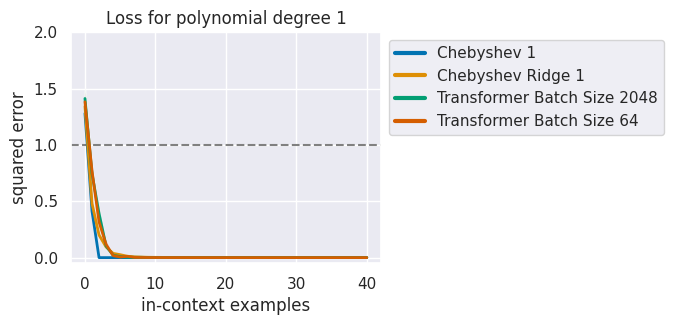

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 2', 'Chebyshev Ridge 2', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


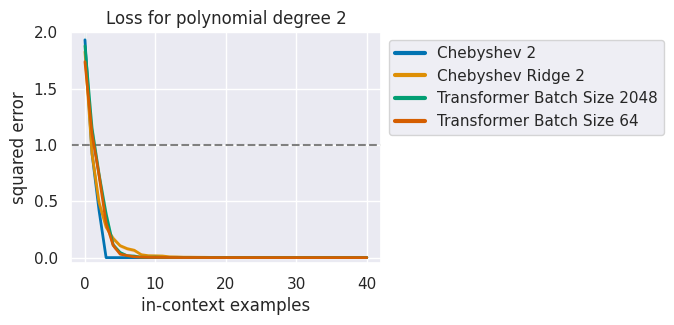

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 3', 'Chebyshev Ridge 3', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


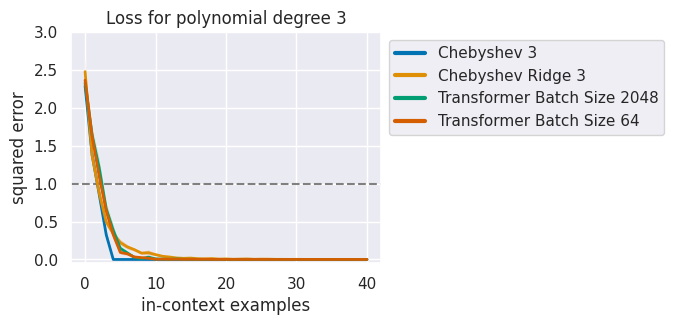

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 4', 'Chebyshev Ridge 4', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


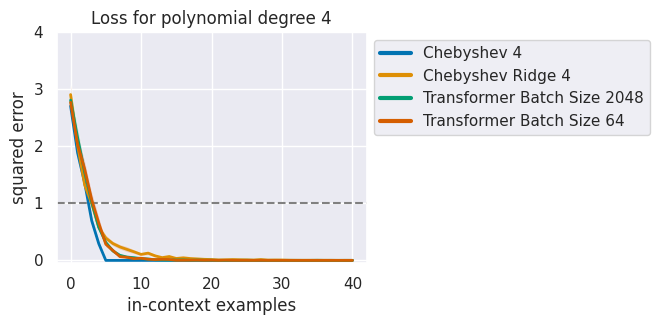

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 5', 'Chebyshev Ridge 5', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


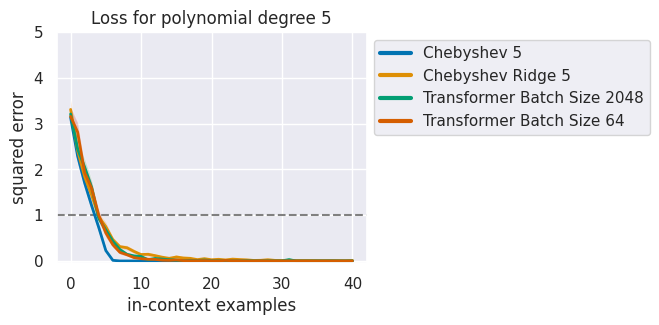

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 6', 'Chebyshev Ridge 6', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


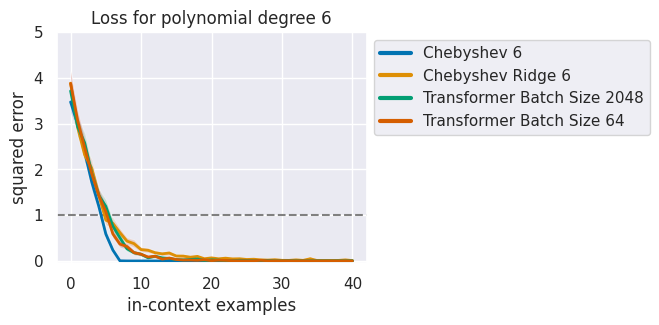

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 7', 'Chebyshev Ridge 7', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


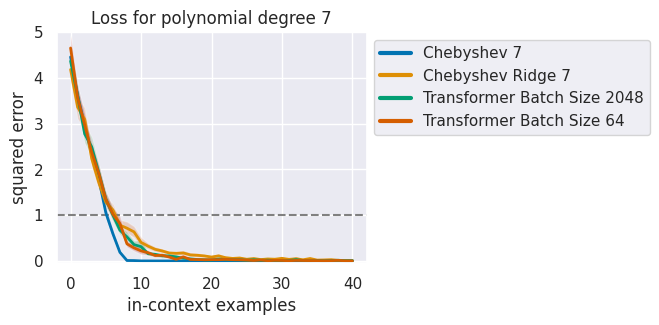

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 8', 'Chebyshev Ridge 8', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


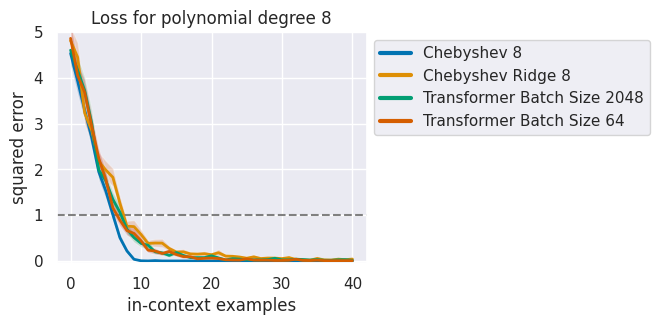

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 9', 'Chebyshev Ridge 9', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


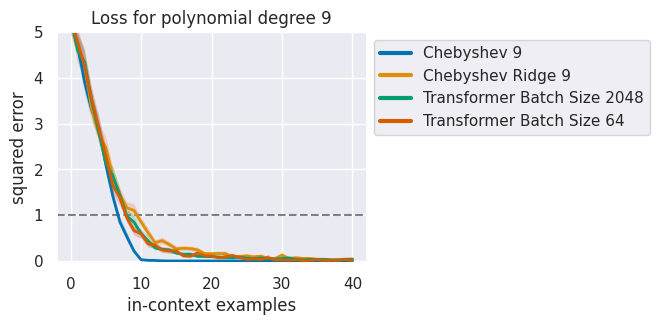

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 10', 'Chebyshev Ridge 10', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


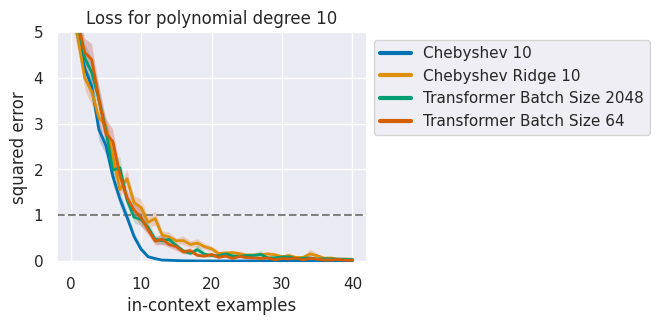

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 11', 'Chebyshev Ridge 11', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


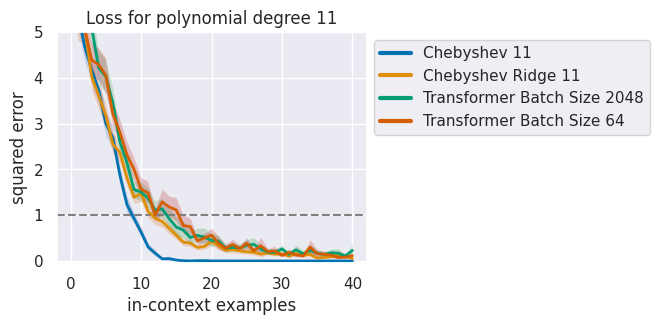

In [4]:
def valid_row(r, run_id):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.00)
print(metrics["degree-" + str(1)])
#metrics_smooth = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.01)
#metrics_big = collect_results(run_dir, df, valid_row= lambda x: valid_row(x, run_id_big), smoothing=0.00)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

#for k, v in metrics_big.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2] = v2
#for k, v in metrics_smooth.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2+ " Smoothed"] = v2

ylims = [2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5]
for degree in range(1, 12):
    models = get_model_names_for_degree(degree)
    print(models)
    print(metrics.keys())
    print(metrics["degree-" + str(degree)].keys())
    basic_plot(metrics["degree-" + str(degree)], models=models, ylim=ylims[degree-1])
    plt.title("Loss for polynomial degree " + str(degree))
    plt.savefig("graphs/degree-" + str(degree) + ".png", dpi=300, bbox_inches='tight')
    plt.show()